In [1]:
import os
import pandas as pd
from IPython.display import display

# ---------- Settings ----------
DATA_PATH = "data"         # your folder
SAMPLE_ROWS = 3            # how many sample rows to show
ADD_SOURCE_COL = True      # keep origin filename in a column
LOW_MEMORY = False         # set True if memory is tight

# If you know a unique key per schema (e.g., "id" for listings), you can map it here to dedupe faster:
# Example: {("id","host_id",...): ["id"]}  -> key is the exact sorted column set of that schema
DEDUP_SUBSET_BY_SCHEMA = {}  # leave empty to dedupe on all columns

# ---------- Discover CSVs ----------
csv_files = [f for f in os.listdir(DATA_PATH) if f.lower().endswith(".csv")]
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in '{DATA_PATH}'")

print(f"Found {len(csv_files)} CSV files in '{DATA_PATH}'.\n")

# ---------- Load & group by schema (set of column names) ----------
# groups: {schema_key(tuple of sorted col names): [(filename, df), ...]}
groups = {}

for file in sorted(csv_files):
    path = os.path.join(DATA_PATH, file)
    try:
        df = pd.read_csv(path, low_memory=LOW_MEMORY)
    except Exception as e:
        print(f"⚠️  Skipping '{file}' due to read error: {e}")
        continue

    schema_key = tuple(sorted(df.columns.tolist()))
    groups.setdefault(schema_key, []).append((file, df))

print(f"Detected {len(groups)} schema group(s) based on column sets.\n")

# ---------- Dedupe within groups (cross-file) ----------
clean_groups = {}  # {schema_key: combined_df_clean}
per_file_rows_kept = []  # reporting

for schema_key, items in groups.items():
    # Keep original column order from the first file in this group
    first_cols = items[0][1].columns.tolist()

    # Concat all files in group, aligning by column name
    dfs = []
    for fname, df in items:
        df = df.copy()
        if ADD_SOURCE_COL:
            df["_source"] = fname
        dfs.append(df)

    combined = pd.concat(dfs, ignore_index=True)

    before = len(combined)
    # Decide subset for dedup (exclude _source so identical rows across files collapse)
    subset_cols = [c for c in combined.columns if c != "_source"]
    # If user defined a specific subset for this schema, use it
    if schema_key in DEDUP_SUBSET_BY_SCHEMA:
        subset_cols = DEDUP_SUBSET_BY_SCHEMA[schema_key]

    combined_clean = combined.drop_duplicates(subset=subset_cols, keep="first").reset_index(drop=True)
    after = len(combined_clean)
    removed = before - after

    # For per-file reporting: how many rows from each file survived the global dedup
    if ADD_SOURCE_COL:
        counts = combined_clean["_source"].value_counts().to_dict()
    else:
        # If _source not present, we can’t attribute; fall back to NaN
        counts = {}

    # Reorder columns to put _source at the end (nicer view)
    cols = [c for c in first_cols if c in combined_clean.columns]  # keep known order first
    other_cols = [c for c in combined_clean.columns if c not in cols and c != "_source"]
    ordered = cols + other_cols + (["_source"] if ADD_SOURCE_COL and "_source" in combined_clean.columns else [])
    combined_clean = combined_clean.reindex(columns=ordered)

    clean_groups[schema_key] = combined_clean

    # Collect report
    per_file_rows_kept.append({
        "schema_cols_count": len(schema_key),
        "files_in_group": len(items),
        "rows_before": before,
        "rows_after": after,
        "duplicates_removed": removed,
        "files": [fname for fname, _ in items],
        "kept_by_file": counts
    })

# ---------- Summary printout ----------
print("\n================== DEDUP SUMMARY (by schema group) ==================\n")
for i, report in enumerate(per_file_rows_kept, start=1):
    print(f"Group {i}: {report['files_in_group']} file(s), {report['schema_cols_count']} column(s)")
    print("   Files:", ", ".join(report["files"]))
    print(f"   Rows before: {report['rows_before']:,}")
    print(f"   Rows after:  {report['rows_after']:,}")
    print(f"   Duplicates removed across files: {report['duplicates_removed']:,}")
    if report["kept_by_file"]:
        print("   Rows kept per file after global dedup:")
        for fname, cnt in report["kept_by_file"].items():
            print(f"      - {fname}: {cnt:,}")
    print("-" * 60)

# ---------- Basic info for each cleaned combined dataset ----------
print("\n================== DATASET PROFILES (cleaned, per group) ==================\n")
for idx, (schema_key, df) in enumerate(clean_groups.items(), start=1):
    print(f"📊 Cleaned Group {idx} (columns: {len(schema_key)})")
    print(f"   Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print("   Columns:", list(df.columns))
    print("   Missing values per column:")
    print(df.isnull().sum().to_string())
    print("\n   Sample data:")
    display(df.head(SAMPLE_ROWS))
    print("-" * 80)

# ---------- Optional: expose cleaned DataFrames ----------
# You can access each cleaned group DataFrame in `clean_groups`.
# Example to get the first cleaned dataset:
# cleaned_any = next(iter(clean_groups.values()))


Found 4 CSV files in 'data'.

Detected 2 schema group(s) based on column sets.


================== DEDUP SUMMARY (by schema group) ==================

Group 1: 1 file(s), 75 column(s)
   Files: listings20241207.csv
   Rows before: 10,032
   Rows after:  10,032
   Duplicates removed across files: 0
   Rows kept per file after global dedup:
      - listings20241207.csv: 10,032
------------------------------------------------------------
Group 2: 3 file(s), 79 column(s)
   Files: listings20250302.csv, listings20250609.csv, listings20250911.csv
   Rows before: 30,723
   Rows after:  30,723
   Duplicates removed across files: 0
   Rows kept per file after global dedup:
      - listings20250911.csv: 10,480
      - listings20250609.csv: 10,168
      - listings20250302.csv: 10,075
------------------------------------------------------------

================== DATASET PROFILES (cleaned, per group) ==================

📊 Cleaned Group 1 (columns: 75)
   Shape: 10032 rows × 76 columns
   Columns

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,_source
0,290701,https://www.airbnb.com/rooms/290701,20241207054011,2024-12-07,city scrape,"Central, big window, rear room with private bath.",((I have a minimum 3 night stay policy. 1 or 2...,The home is in the heart of the city but is su...,https://a0.muscache.com/pictures/airflow/Hosti...,1491565,...,4.92,4.75,0363 DF01 FBC0 496B 9730,t,2,0,2,0,3.05,listings20241207.csv
1,291752,https://www.airbnb.com/rooms/291752,20241207054011,2024-12-07,city scrape,Cozy & large bohemian style room,Cozy spacious room in a beautiful and spiritua...,It is a calm yet atmospheric residential area ...,https://a0.muscache.com/pictures/250e82ad-b80b...,1511330,...,4.79,4.73,0363 6ACC BA1B 12A9 60C1,f,1,0,1,0,1.72,listings20241207.csv
2,304082,https://www.airbnb.com/rooms/304082,20241207054011,2024-12-07,city scrape,"Private, quiet studio in the centre with terrace","We offer a cosy, quiet studio in the very cent...",NaN,https://a0.muscache.com/pictures/a85c2467-eec4...,276068,...,4.88,4.58,0363 6C40 7413 ADD3 9AF8,f,1,1,0,0,2.15,listings20241207.csv


--------------------------------------------------------------------------------
📊 Cleaned Group 2 (columns: 79)
   Shape: 30723 rows × 80 columns
   Columns: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,_source
0,2818,https://www.airbnb.com/rooms/2818,20250302144653,2025-03-03,city scrape,Quiet Garden View Room & Super Fast Wi-Fi,Quiet Garden View Room & Super Fast Wi-Fi,"Indische Buurt (""Indies Neighborhood"") is a ne...",https://a0.muscache.com/pictures/10272854/8dcc...,3159,...,4.73,4.80,0363 5F3A 5684 6750 D14D,f,1,0,1,0,2.05,listings20250302.csv
1,27886,https://www.airbnb.com/rooms/27886,20250302144653,2025-03-03,previous scrape,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,"Central, quiet, safe, clean and beautiful.",https://a0.muscache.com/pictures/02c2da9d-660e...,97647,...,4.89,4.77,0363 974D 4986 7411 88D8,f,1,0,1,0,1.84,listings20250302.csv
2,28871,https://www.airbnb.com/rooms/28871,20250302144653,2025-03-03,city scrape,Comfortable double room,Basic bedroom in the center of Amsterdam.,"Flower market , Leidseplein , Rembrantsplein",https://a0.muscache.com/pictures/160889/362340...,124245,...,4.94,4.83,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,3.83,listings20250302.csv


--------------------------------------------------------------------------------


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load your file
df = pd.read_csv("data/listings20250911.csv")

# Drop duplicates (both within and across datasets if you load multiple later)
df = df.drop_duplicates()

# Summary statistics
display(df.describe(include='all').transpose())

# Check missing values
missing = df.isnull().mean().sort_values(ascending=False)
print("\nMissing values (%):")
print(missing.head(10))

# Correlation heatmap for numerical variables
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,10480.0,NaN,NaN,NaN,592546397015783936.0,562067488034233600.0,27886.0,26293728.25,689347426246034560.0,1119610195817792000.0,1506287353709120512.0
listing_url,10480,10480,https://www.airbnb.com/rooms/1502002221862815389,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scrape_id,10480.0,NaN,NaN,NaN,20250911031321.0,0.0,20250911031321.0,20250911031321.0,20250911031321.0,20250911031321.0,20250911031321.0
last_scraped,10480,1,2025-09-11,10480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source,10480,2,city scrape,5932,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
calculated_host_listings_count,10480.0,NaN,NaN,NaN,1.844084,3.159096,1.0,1.0,1.0,1.0,35.0
calculated_host_listings_count_entire_homes,10480.0,NaN,NaN,NaN,1.217748,2.433486,0.0,1.0,1.0,1.0,32.0
calculated_host_listings_count_private_rooms,10480.0,NaN,NaN,NaN,0.560115,1.713971,0.0,0.0,0.0,0.0,15.0
calculated_host_listings_count_shared_rooms,10480.0,NaN,NaN,NaN,0.029103,0.409605,0.0,0.0,0.0,0.0,9.0



Missing values (%):
neighbourhood_group_cleansed    1.000000
calendar_updated                1.000000
host_neighbourhood              0.733779
neighbourhood                   0.504580
neighborhood_overview           0.504580
host_about                      0.474237
estimated_revenue_l365d         0.439504
price                           0.439504
beds                            0.436641
bathrooms                       0.433969
dtype: float64


NameError: name 'num_cols' is not defined

<Figure size 1000x800 with 0 Axes>

In [6]:
# --- Install once per environment (uncomment if needed) ---
# !pip install folium pandas numpy

import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from branca.element import Element
from string import Template

# ================== SETTINGS ==================
DATA_PATH = "data/listings20250911.csv"   # path to your InsideAirbnb CSV
COL_LAT = "latitude"
COL_LON = "longitude"
COL_PRICE = "price"
COL_RATING = "review_scores_rating"
COL_NAME = "name"          # optional for popup
ZOOM_START = 12

HEAT_RADIUS = 12
HEAT_BLUR = 18
MAX_ZOOM = 13
MAX_MARKERS = 1500
PRICE_UPPER_Q = 0.95  # cap top 5% of prices to avoid distortion

# ================== LOAD & CLEAN ==================
df = pd.read_csv(DATA_PATH).drop_duplicates()
df = df.dropna(subset=[COL_LAT, COL_LON])

# --- Clean price ---
if df[COL_PRICE].dtype == object:
    df[COL_PRICE] = (
        df[COL_PRICE].astype(str)
        .str.replace(r"[^\d\.\-]", "", regex=True)
    )
df[COL_PRICE] = pd.to_numeric(df[COL_PRICE], errors="coerce")

# --- Clean rating ---
df[COL_RATING] = pd.to_numeric(df[COL_RATING], errors="coerce")
df = df.dropna(subset=[COL_PRICE, COL_RATING])

# --- Normalize rating ---
rating_max = df[COL_RATING].max()
rating_scale = 100.0 if rating_max > 5 else 5.0
df["_rating_norm"] = (df[COL_RATING] / rating_scale).clip(0, 1)

# --- Winsorize & normalize price ---
p95 = df[COL_PRICE].quantile(PRICE_UPPER_Q)
df["_price_capped"] = np.minimum(df[COL_PRICE], p95)
p_min, p_max = df["_price_capped"].min(), df["_price_capped"].max()
df["_price_norm"] = 0.0 if p_max == p_min else (df["_price_capped"] - p_min) / (p_max - p_min)

# ================== BUILD MAP ==================
center_lat = df[COL_LAT].mean()
center_lon = df[COL_LON].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=ZOOM_START, tiles="CartoDB positron")

# --- Price Heat Layer ---
price_heat = HeatMap(
    df[[COL_LAT, COL_LON, "_price_norm"]].values.tolist(),
    radius=HEAT_RADIUS, blur=HEAT_BLUR, max_zoom=MAX_ZOOM,
    min_opacity=0.2,
    gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 0.8: 'red'},
)
price_layer = folium.FeatureGroup(name="Price Heatmap", show=True)
price_layer.add_child(price_heat)
m.add_child(price_layer)

# --- Rating Heat Layer ---
rating_heat = HeatMap(
    df[[COL_LAT, COL_LON, "_rating_norm"]].values.tolist(),
    radius=HEAT_RADIUS, blur=HEAT_BLUR, max_zoom=MAX_ZOOM,
    min_opacity=0.2,
    gradient={0.2: '#d3d3d3', 0.4: '#9acd32', 0.6: '#32cd32', 0.8: '#006400'},
)
rating_layer = folium.FeatureGroup(name="Rating Heatmap", show=False)
rating_layer.add_child(rating_heat)
m.add_child(rating_layer)

# --- Popups (no clustering) ---
def popup_text(row):
    name = f"<b>{str(row.get(COL_NAME, 'Listing'))[:60]}</b>"
    price_s = f"€{row[COL_PRICE]:.0f}" if pd.notna(row[COL_PRICE]) else "N/A"
    rating_s = f"{row[COL_RATING]:.1f}" if pd.notna(row[COL_RATING]) else "N/A"
    return f"{name}<br>Price: {price_s}<br>Rating: {rating_s}"

marker_df = df.sample(min(len(df), MAX_MARKERS), random_state=42)
for _, row in marker_df.iterrows():
    folium.CircleMarker(
        location=[row[COL_LAT], row[COL_LON]],
        radius=2.5,
        color=None,
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_text(row), max_width=300),
    ).add_to(m)

# --- Layer control ---
folium.LayerControl(collapsed=False).add_to(m)

# ================== LEGENDS ==================
price_med = float(df[COL_PRICE].median())
rating_med = float(df[COL_RATING].median())

# ---- Price Legend ----
price_tpl = Template("""
<div style="
 position: fixed; bottom: 20px; left: 20px; z-index: 999999;
 background: rgba(255,255,255,0.9); padding: 10px 12px;
 border: 2px solid #777; border-radius: 6px; font-size: 12px; line-height: 1.2;">
  <div style="font-weight: 600; margin-bottom: 6px;">Price (€/night)</div>
  <div style="width: 180px; height: 12px; 
              background: linear-gradient(to right, blue, lime, orange, red);
              border: 1px solid #999;"></div>
  <div style="display:flex; justify-content: space-between; margin-top: 4px;">
    <span>min: €$minp</span>
    <span>median: €$medp</span>
    <span>max*: €$maxp</span>
  </div>
  <div style="margin-top: 4px; color:#555;">*max uses ${pct}th pct cap: €$cap</div>
</div>
""")

legend_price_html = price_tpl.substitute(
    minp=f"{p_min:.0f}",
    medp=f"{price_med:.0f}",
    maxp=f"{p_max:.0f}",
    pct=int(PRICE_UPPER_Q * 100),
    cap=f"{p95:.0f}",
)

# ---- Rating Legend ----
rating_tpl = Template("""
<div style="
 position: fixed; bottom: 20px; right: 20px; z-index: 999999;
 background: rgba(255,255,255,0.9); padding: 10px 12px;
 border: 2px solid #777; border-radius: 6px; font-size: 12px; line-height: 1.2;">
  <div style="font-weight: 600; margin-bottom: 6px;">Rating (0–$rscale)</div>
  <div style="width: 180px; height: 12px; 
              background: linear-gradient(to right, #d3d3d3, #9acd32, #32cd32, #006400);
              border: 1px solid #999;"></div>
  <div style="display:flex; justify-content: space-between; margin-top: 4px;">
    <span>min: $minr</span>
    <span>median: $medr</span>
    <span>max: $maxr</span>
  </div>
  <div style="margin-top: 4px; color:#555;">Intensity scaled to 0–1 range</div>
</div>
""")

legend_rating_html = rating_tpl.substitute(
    rscale=int(rating_scale),
    minr=f"{df[COL_RATING].min():.1f}",
    medr=f"{rating_med:.1f}",
    maxr=f"{df[COL_RATING].max():.1f}",
)

m.get_root().html.add_child(Element(legend_price_html))
m.get_root().html.add_child(Element(legend_rating_html))

# ================== DISPLAY MAP ==================
m


In [11]:
# !pip install pandas numpy scipy statsmodels patsy

import itertools, warnings, time, os
import numpy as np, pandas as pd
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# ================= CONFIG (tune these) =================
CSV_PATH = "data/listings20250911.csv"

SAMPLE_ROWS = 20000          # subsample for speed; set None to use all
MAX_LEVELS_CATEGORICAL = 15  # ignore categoricals with more levels
MAX_ASSOC_NUMNUM = 120       # cap number of numeric↔numeric pairs tested
MAX_ASSOC_CATNUM = 200       # cap number of cat↔num tests
MAX_ASSOC_CATCAT = 60        # cap number of cat↔cat tests

OUTCOME_WHITELIST = ["price","review_scores_rating","availability_365","host_is_superhost"]  # use if present
MAX_INTERACTION_PREDICTORS = 6     # per outcome, keep top-k
INTERACTION_MIN_N = 200            # skip fits with fewer rows
ASSOCIATIONS_TIME_BUDGET_S = 60    # stop association scan after this many seconds
INTERACTIONS_TIME_BUDGET_S = 120   # stop interaction scan after this many seconds
ALPHA = 0.05

SAVE_PREFIX = "screening"
# =======================================================

t0 = time.time()

def load_data(path):
    df = pd.read_csv(path)
    if SAMPLE_ROWS and len(df) > SAMPLE_ROWS:
        df = df.sample(SAMPLE_ROWS, random_state=42).reset_index(drop=True)
    # Clean price-like columns
    for col in df.columns:
        lc = col.lower()
        if "price" in lc or lc.endswith("_fee") or "security_deposit" in lc or "cleaning_fee" in lc:
            if df[col].dtype == object:
                df[col] = df[col].astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
                df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def is_binary(s: pd.Series) -> bool:
    vals = pd.unique(s.dropna())
    if len(vals) <= 10:
        canon = set(map(lambda x: str(x).strip().lower(), vals))
        return canon.issubset({"0","1","true","false","t","f","yes","no","y","n"})
    return False

IGNORE_SUBSTR = {
    "url","http","https","thumbnail","picture","host_url","listing_url",
    "scrape_id","id_", "_id", "description","summary","amenities","notes",
    "transit","access","interaction","house_rules","neighborhood","space"
}

def should_ignore(col: str) -> bool:
    c = col.lower()
    return any(s in c for s in IGNORE_SUBSTR)

# ---- type inference
def infer_types(df):
    types = {}
    for c in df.columns:
        if should_ignore(c):
            types[c] = "text"; continue
        s = df[c]
        if pd.api.types.is_numeric_dtype(s):
            types[c] = "binary" if is_binary(s) else "numeric"
        else:
            nunique = s.nunique(dropna=True)
            types[c] = "categorical" if nunique <= MAX_LEVELS_CATEGORICAL else "text"
    return types

df = load_data(CSV_PATH).drop_duplicates()
types = infer_types(df)

usable = [c for c,t in types.items() if t in ("numeric","binary","categorical")]
num_cols = [c for c in usable if types[c]=="numeric"]
bin_cols = [c for c in usable if types[c]=="binary"]
cat_cols = [c for c in usable if types[c]=="categorical" and df[c].nunique(dropna=True) <= MAX_LEVELS_CATEGORICAL]

print(f"Rows: {len(df):,} | usable columns -> numeric={len(num_cols)}, binary={len(bin_cols)}, categorical={len(cat_cols)}")

# === Helper to cap workload ===
def capped_pairs(items, cap, seed=42):
    items = list(items)
    all_pairs = list(itertools.combinations(items, 2))
    if len(all_pairs) > cap:
        rng = np.random.RandomState(seed)
        idx = rng.choice(len(all_pairs), size=cap, replace=False)
        return [all_pairs[i] for i in idx]
    return all_pairs

# ================= Associations (with budget) =================
assoc_rows = []
t_assoc_start = time.time()

# num-num (Pearson / Spearman quick)
for x,y in capped_pairs(num_cols, MAX_ASSOC_NUMNUM):
    if time.time() - t_assoc_start > ASSOCIATIONS_TIME_BUDGET_S: break
    x1 = df[x]; y1 = df[y]
    m = x1.notna() & y1.notna()
    if m.sum() < 30: continue
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        r,p = stats.pearsonr(x1[m], y1[m])
        rho,p2 = stats.spearmanr(x1[m], y1[m])
    assoc_rows += [
        {"var_x":x,"type_x":"numeric","var_y":y,"type_y":"numeric","method":"pearson_r","effect_size":r,"p_value":p,"n":int(m.sum())},
        {"var_x":x,"type_x":"numeric","var_y":y,"type_y":"numeric","method":"spearman_rho","effect_size":rho,"p_value":p2,"n":int(m.sum())},
    ]

# cat-num (ANOVA via quick OLS)
count = 0
for cat in cat_cols + bin_cols:
    for num in num_cols:
        if time.time() - t_assoc_start > ASSOCIATIONS_TIME_BUDGET_S: break
        if count >= MAX_ASSOC_CATNUM: break
        s = df[[cat,num]].dropna()
        if len(s) < 50 or s[cat].nunique() < 2: continue
        try:
            fit = smf.ols(f"{num} ~ C({cat})", data=s).fit()
            aov = anova_lm(fit, typ=2)
            ss_cat = aov.loc[f"C({cat})","sum_sq"]
            eta2 = float(ss_cat / (ss_cat + aov.loc["Residual","sum_sq"]))
            assoc_rows.append({"var_x":cat,"type_x":"categorical","var_y":num,"type_y":"numeric",
                               "method":"anova_eta2","effect_size":eta2,"p_value":float(aov.loc[f"C({cat})","PR(>F)"]),
                               "n":len(s)})
            count += 1
        except Exception:
            continue
    if time.time() - t_assoc_start > ASSOCIATIONS_TIME_BUDGET_S or count >= MAX_ASSOC_CATNUM:
        break

# cat-cat (Chi2 on smaller tables only)
count = 0
for x,y in capped_pairs(cat_cols + bin_cols, MAX_ASSOC_CATCAT):
    if time.time() - t_assoc_start > ASSOCIATIONS_TIME_BUDGET_S: break
    tab = pd.crosstab(df[x], df[y])
    if tab.size > 500:  # skip huge tables
        continue
    try:
        chi2,p,_,_ = stats.chi2_contingency(tab)
        # Cramer's V
        n = tab.to_numpy().sum(); r,k = tab.shape
        V = np.sqrt((chi2/n) / max(1, min(k-1, r-1)))
        assoc_rows.append({"var_x":x,"type_x":"categorical","var_y":y,"type_y":"categorical",
                           "method":"chi2_cramers_v","effect_size":V,"p_value":p,"n":int(n)})
        count += 1
    except Exception:
        continue

assoc_df = pd.DataFrame(assoc_rows)
assoc_df.to_csv(f"{SAVE_PREFIX}_associations.csv", index=False)
print(f"Associations: wrote {len(assoc_df)} rows to {SAVE_PREFIX}_associations.csv in {time.time()-t_assoc_start:.1f}s")

# ================= Interactions (with budget) =================
def rank_predictors_for(y, ytype):
    # simple relevance: numeric → |pearson|; categorical → ANOVA eta2; binary Y → point-biserial/chi2
    pool = [c for c in usable if c != y]
    scores = []
    for c in pool:
        s = df[[y,c]].dropna()
        if len(s) < 100: continue
        try:
            if ytype == "numeric":
                if types[c]=="numeric":
                    r,_ = stats.pearsonr(s[y], s[c]); score = abs(r)
                else:
                    fit = smf.ols(f"{y} ~ C({c})", data=s).fit()
                    aov = anova_lm(fit, typ=2)
                    ss = aov.loc[f"C({c})","sum_sq"]; score = float(ss/(ss+aov.loc["Residual","sum_sq"]))
            else: # binary Y
                if types[c]=="numeric":
                    r,_ = stats.pearsonr(s[y].astype(float), s[c].astype(float)); score = abs(r)
                else:
                    tab = pd.crosstab(s[y], s[c])
                    if tab.size > 500: continue
                    _, p, _, _ = stats.chi2_contingency(tab)
                    score = 1 - min(1.0, p)
            scores.append((c, score))
        except Exception:
            continue
    scores.sort(key=lambda t: t[1], reverse=True)
    return [c for c,_ in scores[:MAX_INTERACTION_PREDICTORS]]

# choose outcomes
candidates = [c for c in OUTCOME_WHITELIST if c in df.columns and types.get(c) in ("numeric","binary")]
if not candidates:
    # fallback: top-1 numeric by variance and top-1 binary by balance
    if num_cols:
        var_sorted = sorted(num_cols, key=lambda c: df[c].var(skipna=True), reverse=True)
        candidates += var_sorted[:1]
    if bin_cols:
        # pick binary closest to 50/50
        def balance(c):
            s = df[c].dropna()
            p = s.mean() if set(s.unique())<= {0,1} else (s.astype(str).str.lower().eq("true")).mean()
            return abs(0.5 - float(p))
        candidates += [sorted(bin_cols, key=balance)[0]]

print("Outcomes for interactions:", candidates)

t_int_start = time.time()
inter_rows = []
n_fits = 0

for y in candidates:
    ytype = types[y]
    preds = rank_predictors_for(y, ytype)
    for x1, x2 in itertools.combinations(preds, 2):
        if time.time() - t_int_start > INTERACTIONS_TIME_BUDGET_S: break
        s = df[[y,x1,x2]].dropna()
        if len(s) < INTERACTION_MIN_N: continue
        def term(v): return f"C({v})" if types[v] in ("categorical","binary") else v
        formula = f"{y} ~ {term(x1)} + {term(x2)} + {term(x1)}:{term(x2)}"
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if ytype == "numeric":
                    fit = smf.ols(formula, data=s).fit()
                    p_int = fit.pvalues.filter(like=":").min()
                    inter_rows.append({"outcome":y,"outcome_type":"numeric","x1":x1,"x2":x2,
                                       "model":"OLS_interaction","interaction_p":float(p_int),
                                       "r2":fit.rsquared,"n":len(s)})
                else:
                    fit = smf.logit(formula, data=s).fit(disp=False, maxiter=100, method="lbfgs")
                    p_int = fit.pvalues.filter(like=":").min()
                    pseudo_r2 = 1 - fit.llf/fit.llnull if fit.llnull != 0 else np.nan
                    inter_rows.append({"outcome":y,"outcome_type":"binary","x1":x1,"x2":x2,
                                       "model":"Logit_interaction","interaction_p":float(p_int),
                                       "r2":pseudo_r2,"n":len(s)})
            n_fits += 1
            if n_fits % 20 == 0:
                print(f"  Fitted {n_fits} interaction models…")
        except Exception:
            continue

inter_df = pd.DataFrame(inter_rows)
if not inter_df.empty:
    inter_df["significant"] = inter_df["interaction_p"] < ALPHA
inter_df.to_csv(f"{SAVE_PREFIX}_interactions.csv", index=False)
print(f"Interactions: wrote {len(inter_df)} rows to {SAVE_PREFIX}_interactions.csv in {time.time()-t_int_start:.1f}s")

print(f"Total time: {time.time()-t0:.1f}s")


Rows: 10,480 | usable columns -> numeric=41, binary=2, categorical=10
Associations: wrote 480 rows to screening_associations.csv in 3.9s
Outcomes for interactions: ['price', 'review_scores_rating', 'availability_365']
  Fitted 20 interaction models…
  Fitted 40 interaction models…
Interactions: wrote 45 rows to screening_interactions.csv in 0.8s
Total time: 5.0s


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    data=df, 
    x="review_scores_rating", y="price",
    hue="room_type", 
    scatter_kws={"alpha":0.4}, 
    line_kws={"linewidth":2}
)
plt.title("Relationship Between Rating and Price by Room Type")
plt.show()


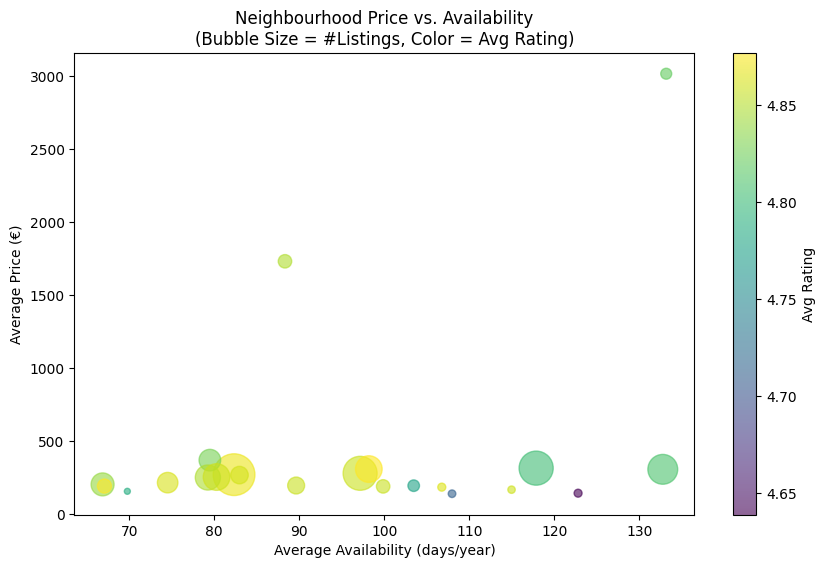

In [8]:
import matplotlib.pyplot as plt

agg = df.groupby("neighbourhood_cleansed", as_index=False).agg({
    "price":"mean",
    "availability_365":"mean",
    "review_scores_rating":"mean",
    "id":"count"
})
agg.rename(columns={"id":"listings"}, inplace=True)

plt.figure(figsize=(10,6))
plt.scatter(agg["availability_365"], agg["price"],
            s=agg["listings"]*0.5, alpha=0.6,
            c=agg["review_scores_rating"], cmap="viridis")
plt.xlabel("Average Availability (days/year)")
plt.ylabel("Average Price (€)")
plt.title("Neighbourhood Price vs. Availability\n(Bubble Size = #Listings, Color = Avg Rating)")
plt.colorbar(label="Avg Rating")
plt.show()


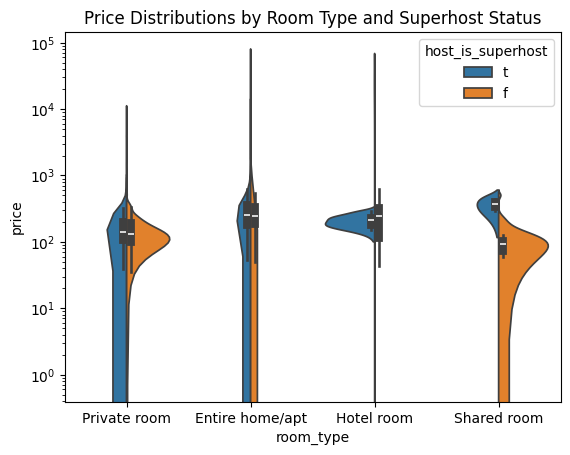

In [5]:
sns.violinplot(data=df, x="room_type", y="price", hue="host_is_superhost", split=True)
plt.yscale("log")  # prices often skewed
plt.title("Price Distributions by Room Type and Superhost Status")
plt.show()


C:\Users\TMaaneman\AppData\Local\Temp\ipykernel_18120\3379902154.py:79: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


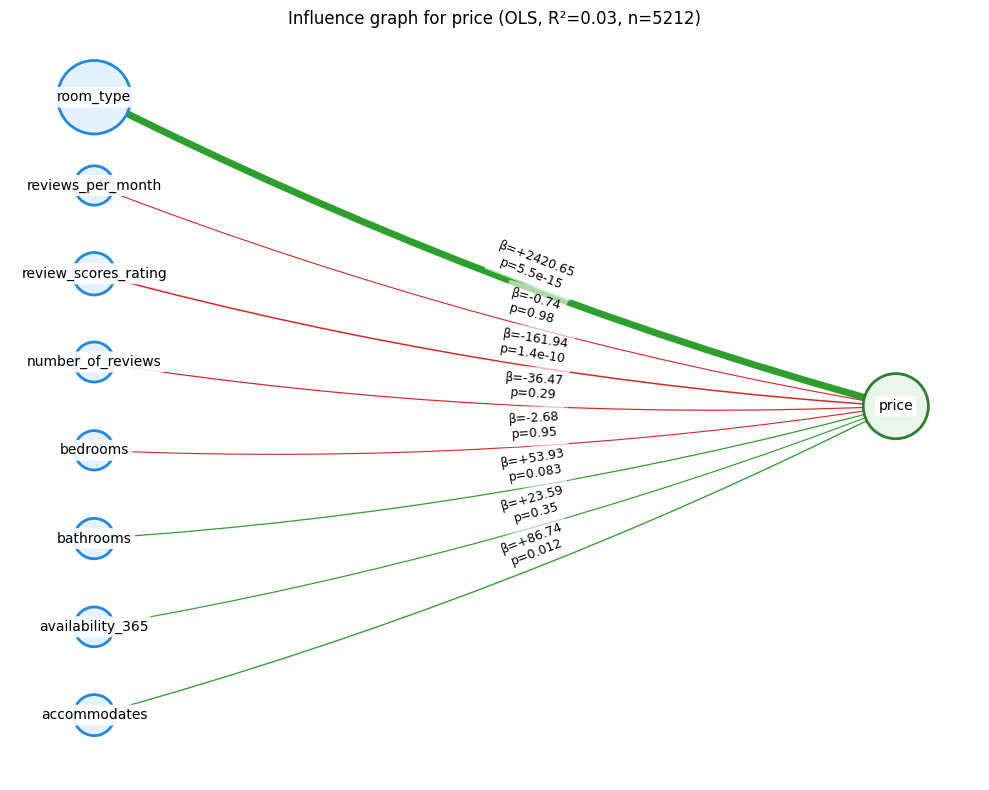

Saved influence graph to: influence_graph_networkx.png


In [29]:
# --- Install once if needed ---
# !pip install graphviz pydot statsmodels patsy

import os
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# ===================== CONFIG =====================
CSV_PATH = "data/listings20250911.csv"

OUTCOME = "price"  # change to e.g. "review_scores_rating" or a binary like "host_is_superhost"
# Pick a small, interpretable set (3–10) from your columns:
PREDICTOR_CANDIDATES = [
    "accommodates", "bedrooms", "bathrooms",
    "room_type", "neighbourhood_cleansed",
    "number_of_reviews", "reviews_per_month",
    "availability_365", "review_scores_rating"
]

MAX_LEVELS_FOR_CATEGORY = 20      # ignore very high-cardinality categoricals
TOP_K_EDGES = 8                   # keep the top-K strongest effects
ALPHA = 0.05                      # show p-values
# ===================================================

# ---------- Load & basic cleaning ----------
df = pd.read_csv(CSV_PATH)
df = df.drop_duplicates()

# Clean price-like fields
for c in df.columns:
    cl = c.lower()
    if ("price" in cl) or cl.endswith("_fee") or ("deposit" in cl) or ("charges" in cl):
        if df[c].dtype == object:
            df[c] = df[c].astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep only predictors present and with data
preds = [c for c in PREDICTOR_CANDIDATES if c in df.columns]
df_model = df[[OUTCOME] + preds].copy()

# Determine outcome type
y = df_model[OUTCOME]
y_type = "binary" if (pd.api.types.is_numeric_dtype(y) and y.dropna().nunique() == 2) else "numeric"

# Build formula: numeric terms as z-scored; categorical as C()
def is_low_card_cat(s):
    return (not pd.api.types.is_numeric_dtype(s)) and (s.nunique(dropna=True) <= MAX_LEVELS_FOR_CATEGORY)

numeric_terms = []
categorical_terms = []
kept = []

for c in preds:
    s = df_model[c]
    if s.isna().all(): 
        continue
    if pd.api.types.is_numeric_dtype(s):
        # z-score for standardized beta
        m = s.mean(skipna=True); sd = s.std(skipna=True)
        if sd and sd > 0:
            df_model[f"z_{c}"] = (s - m) / sd
            numeric_terms.append(f"z_{c}")
            kept.append(c)
    elif is_low_card_cat(s):
        df_model[c] = s.astype("category")
        categorical_terms.append(f"C({c})")
        kept.append(c)
# Drop rows with missing outcome
df_model = df_model.dropna(subset=[OUTCOME])

# Build formula string
rhs_terms = numeric_terms + categorical_terms
if not rhs_terms:
    raise ValueError("No usable predictors after cleaning. Reduce categorical cardinality or add more numeric predictors.")
formula = f"{OUTCOME} ~ " + " + ".join(rhs_terms)

# Fit model
with pd.option_context('mode.use_inf_as_na', True):
    if y_type == "numeric":
        fit = smf.ols(formula, data=df_model).fit()
        # Collect coefficients: for numeric z_ vars, take β directly; for C() dummies, take max |β|
        effects = []
        for c in kept:
            if f"z_{c}" in fit.params.index:
                beta = float(fit.params[f"z_{c}"]); p = float(fit.pvalues[f"z_{c}"])
                effects.append({"u": c, "v": OUTCOME, "beta": beta, "p": p})
            else:
                # categorical: gather all its levels
                idx = [i for i in fit.params.index if i.startswith(f"C({c})[T.")]
                if idx:
                    # pick the level with largest |beta|
                    betas = [(i, float(fit.params[i]), float(fit.pvalues.get(i, np.nan))) for i in idx]
                    i_best, b_best, p_best = sorted(betas, key=lambda t: abs(t[1]), reverse=True)[0]
                    effects.append({"u": c, "v": OUTCOME, "beta": b_best, "p": p_best})
        # Add overall R2 for title
        model_info = {"title": f"Influence graph for {OUTCOME} (OLS, R²={fit.rsquared:.2f}, n={int(fit.nobs)})"}
    else:
        fit = smf.logit(formula, data=df_model).fit(disp=False, maxiter=200)
        # For logit, use standardized betas for numerics; for C(), take max |coef|
        effects = []
        for c in kept:
            if f"z_{c}" in fit.params.index:
                beta = float(fit.params[f"z_{c}"]); p = float(fit.pvalues[f"z_{c}"])
                effects.append({"u": c, "v": OUTCOME, "beta": beta, "p": p})
            else:
                idx = [i for i in fit.params.index if i.startswith(f"C({c})[T.")]
                if idx:
                    betas = [(i, float(fit.params[i]), float(fit.pvalues.get(i, np.nan))) for i in idx]
                    i_best, b_best, p_best = sorted(betas, key=lambda t: abs(t[1]), reverse=True)[0]
                    effects.append({"u": c, "v": OUTCOME, "beta": b_best, "p": p_best})
        ll0 = getattr(fit, "llnull", np.nan)
        pseudo_r2 = (1 - fit.llf/ll0) if (ll0 not in [0, np.nan]) else np.nan
        model_info = {"title": f"Influence graph for {OUTCOME} (Logit, McFadden R²={pseudo_r2:.2f}, n={int(fit.nobs)})"}

# Rank by importance = |beta|
eff = pd.DataFrame(effects)
eff["importance"] = eff["beta"].abs()
eff = eff.sort_values("importance", ascending=False).head(TOP_K_EDGES)

# =================== DRAW THE GRAPH ===================
# Try Graphviz (best). If unavailable, fall back to NetworkX arrows.
HAS_GRAPHVIZ = False
try:
    import graphviz  # noqa
    HAS_GRAPHVIZ = True
except Exception:
    HAS_GRAPHVIZ = False

def draw_graphviz(eff, title):
    from graphviz import Digraph
    dot = Digraph(engine="dot")
    dot.attr(rankdir="LR", splines="spline", fontname="Helvetica", fontsize="12")

    # Node styles
    dot.node(OUTCOME, shape="box", style="filled,rounded", fillcolor="#E8F5E9", color="#2e7d32", penwidth="2")

    # Predictor nodes
    for u in eff["u"].unique():
        dot.node(u, shape="box", style="filled,rounded", fillcolor="#E3F2FD", color="#1e88e5", penwidth="2")

    # Edges with width by importance, color by sign, label with β and p
    for _, r in eff.iterrows():
        beta = r["beta"]; p = r["p"]; imp = r["importance"]
        width = str(0.8 + 4.2 * (imp / (eff["importance"].max() + 1e-9)))
        color = "#2ca02c" if beta > 0 else "#d62728"
        label = f"β={beta:+.2f}, p={p:.3g}"
        dot.edge(r["u"], r["v"], penwidth=width, color=color, arrowsize="0.9", label=label, fontsize="10")

    # group predictors on same rank
    with dot.subgraph() as s:
        s.attr(rank="same")
        for u in eff["u"].unique():
            s.node(u)

    dot.attr(label=title, labelloc="t", fontsize="14")
    outpath = dot.render("influence_graph", format="png", cleanup=True)
    return outpath

def draw_networkx(eff, title):
    import matplotlib.pyplot as plt
    import networkx as nx
    from textwrap import wrap

    G = nx.DiGraph()
    # Node sizes: outcome larger; predictor size by summed importance (only 1 edge each here)
    node_imp = eff.groupby("u")["importance"].sum().to_dict()
    for u in eff["u"].unique():
        G.add_node(u, role="predictor", size=800 + 2000 * (node_imp[u] / (max(node_imp.values()) + 1e-9)))
    G.add_node(OUTCOME, role="outcome", size=2200)

    for _, r in eff.iterrows():
        G.add_edge(r["u"], r["v"], beta=r["beta"], p=r["p"], w=r["importance"])

    # Layered positions: predictors left, outcome right
    pos = {OUTCOME: (1.0, 0.0)}
    ys = np.linspace(-1, 1, num=len(node_imp)) if node_imp else [0]
    for (u, y) in zip(node_imp.keys(), ys):
        pos[u] = (0.0, float(y))

    # Draw
    plt.figure(figsize=(10, 6 + 0.25*len(node_imp)))
    # nodes
    node_sizes = [G.nodes[n]["size"] for n in G.nodes()]
    node_colors = ["#E3F2FD" if G.nodes[n]["role"] == "predictor" else "#E8F5E9" for n in G.nodes()]
    node_edges  = ["#1e88e5" if G.nodes[n]["role"] == "predictor" else "#2e7d32" for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes,
                           edgecolors=node_edges, linewidths=2.0)
    # edges
    widths = [0.8 + 4.2*(d["w"]/(eff["importance"].max()+1e-9)) for _,_,d in G.edges(data=True)]
    colors = ["#2ca02c" if d["beta"]>0 else "#d62728" for _,_,d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="-|>", arrowsize=16,
                           width=widths, edge_color=colors, connectionstyle="arc3,rad=0.05")
    # labels
    lbl = {n: "\n".join(wrap(str(n), 22)) for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=lbl, font_size=10,
                            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.9))
    # edge labels with β and p
    elbl = {(u,v): f"β={d['beta']:+.2f}\np={d['p']:.2g}" for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=elbl, font_size=9, label_pos=0.55, bbox=dict(alpha=0.6, fc="white", ec="none"))

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    outpath = "influence_graph_networkx.png"
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.show()
    return outpath

title = model_info["title"]
if HAS_GRAPHVIZ:
    out = draw_graphviz(eff, title)
else:
    out = draw_networkx(eff, title)

print(f"Saved influence graph to: {out}")
